In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import scipy.optimize as opt

In [2]:
def get_returns(options=["MSFT", "AMZN"], price="Close", start_date="2000-01-01", end_date="2010-01-01"):
    returns = []

    for option in options:

        yf.pdr_override()

        # download dataframe using pandas_datareader
        opt = pdr.get_data_yahoo(option, start=start_date, end=end_date)

        opt_prices = opt[[price]]
        #tesla_prices.plot()

        opt_returns = opt_prices.pct_change()

        returns.append(opt_returns)
        #tesla_var = np.var(tesla_returns)

    nb_returns = len(returns)

    returns = pd.concat(returns, axis=1).T

    del returns[returns.columns[0].strftime("%Y-%m-%d")]

    return returns, nb_returns



In [3]:
returns, nb_returns = get_returns()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def optimize_portfolio(returns, nb_returns):
    V = np.cov(returns)

    w0 = [1/nb_returns]*nb_returns

    def diversification_ratio(w):
        w_vol = np.dot(w.T, np.sqrt(np.diag(V)))

        port_vol = np.sqrt(np.dot(np.dot(w.T, V), w))

        diversification_ratio = w_vol/port_vol

        return -diversification_ratio

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    bnds = ((0, 1),)*nb_returns

    optimized = opt.minimize(diversification_ratio, w0, method='SLSQP', bounds=bnds, constraints=cons)

    return optimized

In [5]:
print(optimize_portfolio(returns, nb_returns).x[0])

0.6500519214190388


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
start_date = 2000-10-01
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
start_date = 2001-01-01
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 o

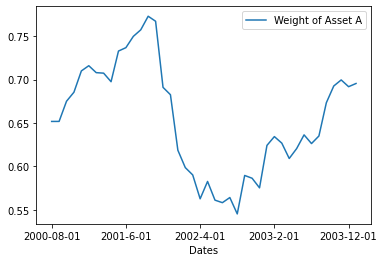

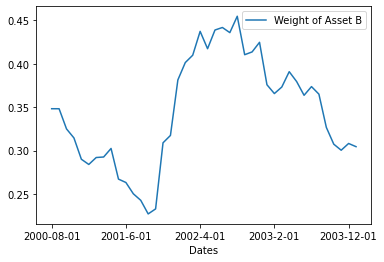

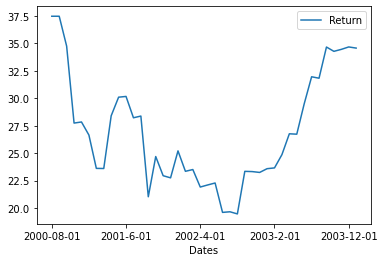

In [6]:
def rolling_v1(options=["MSFT", "AMZN"], price="Close", start_date="2000-08-01", end_date="2005-02-01"):
    P1 = pdr.get_data_yahoo(options[0], start=start_date, end=end_date)
    P2 = pdr.get_data_yahoo(options[1], start=start_date, end=end_date)
    dates = [start_date]
    Wa = [] #liste des poids du premier asset
    Wb = [] #liste des poids du deuxième asset
    R = [] #liste du return en fonction des allocations
    start_date_split = start_date.split("-")
    start_date_int = [int(start_date_split[0]), int(start_date_split[1]), int(start_date_split[2])]
    end_date_split = end_date.split("-")
    end_date_int = [int(end_date_split[0]), int(end_date_split[1]), int(end_date_split[2])]
    timelapse = end_date_int[1] + ((end_date_int[0] - 1) - (start_date_int[0] + 1))*12 + (12 - start_date_int[1]) #on compte le nombre de mois en tout
    for i in range(timelapse) :
        if start_date_int[1] < 12 :
            start_date_int[1] += 1
            start_date_split[1] = str(start_date_int[1])
        else :
            start_date_int[0] += 1
            start_date_split[0] = str(start_date_int[0])
            start_date_split[1] = "01"
            start_date_int[1] = int(start_date_split[1])
        start_date = start_date_split[0] + "-" + start_date_split[1] + "-" + start_date_split[2]
        if start_date_int[1] < 7 :
            end_date_int[1] = start_date_int[1] + 6
            end_date_int[0] = start_date_int[0]
            end_date_int[2] = start_date_int[2]
        else :
            end_date_int[1] = start_date_int[1] - 6
            end_date_int[0] = start_date_int[0] + 1
            end_date_int[2] = start_date_int[2]
        end_date_split = [str(end_date_int[0]), str(end_date_int[1]), str(end_date_int[2])]
        end_date = end_date_split[0] + "-" + end_date_split[1] + "-" + end_date_split[2]

        returns, nb_returns = get_returns(options, price, start_date, end_date)
        opt = optimize_portfolio(returns, nb_returns).x
        wa, wb = opt[0], opt[1]
        Wa.append(wa)
        Wb.append(wb)
        dates.append(start_date)
        while len(R) == i :
            try :
                p1 = P1['Open'][start_date]
                p2 = P2['Open'][start_date]
            except :
                start_date_split = start_date.split("-")
                start_date_int = [int(start_date_split[0]), int(start_date_split[1]), int(start_date_split[2])]
                if start_date_int[2] < 30 :
                    start_date_int[2] += 1
                elif start_date_int[1] < 12 :
                    start_date_int[2] = 1
                    start_date_int[1] += 1
                else : 
                    start_date_int[2] = 1
                    start_date_int[1] = 1
                    start_date_int[0] += 1
                start_date = str(start_date_split[0]) + "-" + str(start_date_split[1]) + "-" + str(start_date_split[2])
                print("start_date =", start_date)
            R.append(wa*p1 + wb*p2)
    df = pd.DataFrame(list(zip(dates, Wa, Wb, R)), columns = ['Dates', 'Weight of Asset A', 'Weight of Asset B', 'Return'])
    df.plot(x="Dates", y="Weight of Asset A")
    df.plot(x="Dates", y="Weight of Asset B")
    df.plot(x="Dates", y="Return")
        
        
        
rolling_v1()

In [7]:
start = "2000-01-01"
spl = start.split("-")
print(spl)
oui = [int(spl[0]), int(spl[1]), int(spl[2])]
non = [str(oui[0]), str(oui[1]), str(oui[2])]
start_date = str(non[0]) + "-" + str(non[1]) + "-" + str(non[2])
print(type(start_date))

['2000', '01', '01']
<class 'str'>
